# Обзор базовых подходов к решению задачи Uplift Моделирования

<br>
<center> 
  <b><a href="https://github.com/maks-sh/scikit-uplift/">SCIKIT-UPLIFT REPO</a> | </b>
  <b><a href="https://nbviewer.jupyter.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero_EN.ipynb">ENGLISH VERSION</a> | </b>
  <b><a href="https://habr.com/ru/company/ru_mts/blog/485980/">СТАТЬЯ НА HABR</a></b>
</center>

## Содержание

* [Введение](#Введение)
* [1. Подходы с одной моделью](#1.-Подходы-с-одной-моделью)
    * [1.1 Одна модель](#1.1-Одна-модель-с-признаком-коммуникации)
    * [1.2 Трансформация классов](#1.2-Трансформация-классов)
* [2. Подходы с двумя моделями](#2.-Подходы-с-двумя-моделями)
    * [2.1 Две независимые модели](#2.1-Две-независимые-модели)
    * [2.2 Две зависимые модели](#2.3-Две-зависимые-модели)
* [Заключение](#Заключение)

## Введение

Прежде чем переходить к обсуждению uplift моделирования, представим некоторую ситуацию.

К вам приходит заказчик с некоторой проблемой: необходимо с помощью sms рассылки прорекламировать достаточно популярный продукт.
У вас как у самого настоящего, топового дата саентиста в голове уже вырисовался план:

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/memchik_RU.png" alt="Топовый дс"/>
</p>

И тут вы начинаете понимать, что продукт и без того популярный, что без коммуникации продукт достаточно часто устанавливается клиентами, что обычная бинарная классификация обнаружит много таких клиентов, а стоимость коммуникация для нас критична...

Исторически, по воздействию коммуникации маркетологи разделяют всех клиентов на 4 категории:

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/client_types_RU.png" alt="Категории клиентов"/>
</p>

1. **Спящая собака** - человек, который будет реагировать негативно, если с ним прокоммуницировать. Яркий пример: клиенты, которые забыли про платную подписку. Получив напоминание об этом, они обязательно ее отключат. Но если их не трогать, то клиенты по-прежнему будут приносить деньги.
2. **Потерянный** - человек, который не совершит целевое действие независимо от коммуникаций. Взаимодействие с такими клиентами не приносит дополнительного дохода, но создает дополнительные затраты.
3. **Уверенный (Лояльный)** - человек, который будет реагировать положительно, несмотря ни на что - самый лояльный вид клиентов. По аналогии с предыдущим пунктом, такие клиенты также расходуют ресурсы. Однако в данном случае расходы гораздо больше, так как **уверенные** еще и пользуются маркетинговым предложением (скидками, купонами и другое).
4. **Убеждаемый** - это человек, который положительно реагирует на предложение, но при его отсутствии не выполнил бы целевого действия. Это те люди, которых мы хотели бы определить нашей моделью, чтобы с ними прокоммуницировать.

Стоит отметить, что в зависимости от клиентской базы и особенностей компании возможно отсутствие некоторых из этих типов клиентов.

Таким образом, в данной задаче нам хочется не просто спрогнозировать вероятность выполнения целевого действия, а сосредоточить рекламный бюджет на клиентах, которые выполнят целевое действие только при нашем взаимодействии. Иначе говоря, для каждого клиента хочется отдельно оценить две условные вероятности:

* Выполнение целевого действия при нашем воздействии на клиента. 
    Таких клиентов будем относить к **тестовой группе (aka treatment)**: $P^T = P(Y=1 | W = 1)$,
* Выполнение целевого действия без воздействия на клиента. 
    Таких клиентов будем относить к **контрольной группе (aka control)**: $P^C = P(Y=1 | W = 0)$,

где $Y$ - бинарный флаг выполнения целевого действия, $W$ - бинарный флаг наличия коммуникации (в англоязычной литературе - _treatment_)

Сам же причинно-следственный эффект **называется uplift** и оценивается как разность двух этих вероятностей:

$$ uplift = P^T - P^C = P(Y = 1 | W = 1) - P(Y = 1 | W = 0)$$

Прогнозирование uplift - это задача причинно-следственного вывода. Дело в том, что нужно оценить разницу между двумя событиями, которые являются взаимоисключающими для конкретного клиента (либо мы взаимодействуем с человеком, либо нет; нельзя одновременно совершить два этих действия). Именно поэтому для построения моделей uplift предъявляются дополнительные требования к исходным данным.

Для получения обучающей выборки для моделирования uplift необходимо провести эксперимент: 
1. Случайным образом разбить репрезентативную часть клиентской базы на тестовую и контрольную группу
2. Прокоммуницировать с тестовой группой

Данные, полученные в рамках дизайна такого пилота, позволят нам в дальнейшем построить модель прогнозирования uplift. Стоит также отметить, что эксперимент должен быть максимально похож на кампнию, которая будет запущена позже в более крупном масштабе. Единственным отличием эксперимента от кампании должен быть тот факт, что во время пилота для взаимодействия мы выбираем случайных клиентов, а во время кампании - на основе спрогнозированного значения Uplift. Если кампания, которая в конечном итоге запускается, существенно отличается от эксперимента, используемого для сбора данных о выполнении целевых действий клиентами, то построенная модель может быть менее надежной и точной.

Итак, подходы к прогнозированию uplift направлены на оценку чистого эффекта от воздействия маркетинговых кампаний на клиентов.

**Подробнее про uplift можно прочитать в [цикле статьй на хабре](https://habr.com/ru/company/ru_mts/blog/485980/).**

Все классические подходы к моделированию uplift можно разделить на два класса:
1. Подходы с применением одной моделью
2. Подходы с применением двух моделей

Импортируем нужные библиотеки, считаем [данные конкурса RetailHero.ai](https://retailhero.ai/c/uplift_modeling/overview) и немного их предобработаем:

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Чтение данных
df_clients = pd.read_csv('./RetailHero-data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./RetailHero-data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./RetailHero-data/uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = pd.to_datetime(df_features['first_issue_date']).astype(int) / 10 ** 9
df_features['first_redeem_time'] = pd.to_datetime(df_features['first_redeem_date']).astype(int) / 10 ** 9
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

Для удобства объявим некоторые переменные:

In [2]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1. Подходы с одной моделью

### 1.1 Одна модель с признаком коммуникации

Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.


<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel_RU.png" alt="Solo model with treatment as a feature"/>
</p>

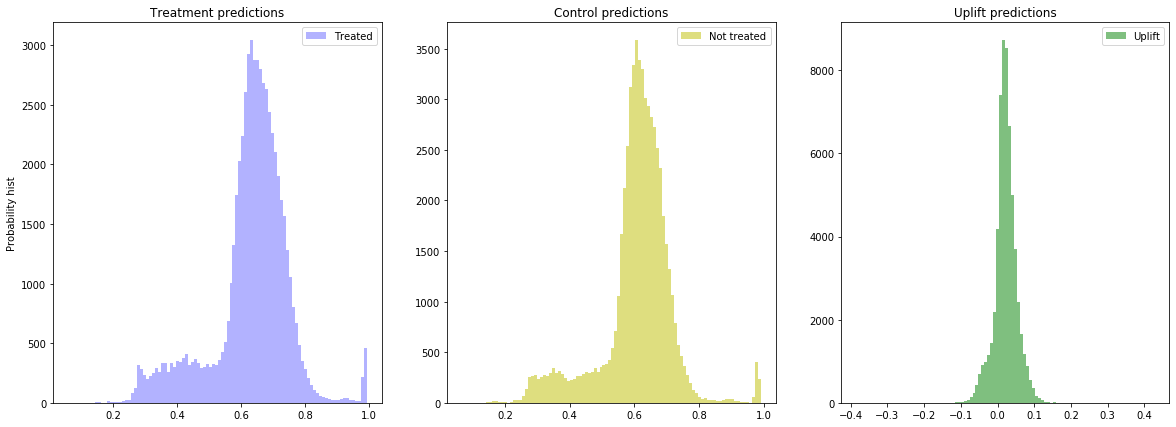

In [3]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Инстркция на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [4]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,57.265014
1,issue_redeem_delay,15.511906
2,age,11.130900
3,first_issue_time,10.264423
4,gender,3.501024
5,treatment,2.326734


### 1.2 Трансформация классов

Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$
z_i = y_i * w_i + (1 - y_i) * (1 - w_i),
$$
где 

* $z_i$ - новая целевая переменная $i$-ого клиента; 
* $y_i$ - целевая перемнная $i$-ого клиента;
* $w_i$ - флаг коммуникации $i$-ого клиента;  


Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:

$$
z_i = \begin{cases} 
    1, & \mbox{если } w_i = 1 \mbox{ и } y_i = 1 \\ 
    1, & \mbox{если } w_i = 0 \mbox{ и } y_i = 0 \\
    0, & \mbox{в остальных случаях} 
   \end{cases}
$$

Распишем подробнее, чему равна вероятность новой целевой переменной:

$$ 
P(Z=1|X_1, ..., X_m) = \\
= P(Z=1|X_1, ..., X_m, W = 1) * P(W = 1|X_1, ..., X_m, ) + \\
+ P(Z=1|X_1, ..., X_m, W = 0) * P(W = 0|X_1, ..., X_m, ) = \\
= P(Y=1|X_1, ..., X_m, W = 1) * P(W = 1|X_1, ..., X_m, ) + \\
+ P(Y=0|X_1, ..., X_m, W = 0) * P(W = 0|X_1, ..., X_m, ).
$$

Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и 

$$
P(Z=1|X_1, ..., X_m) = \\
= P^T(Y=1|X_1, ..., X_m) * P(W = 1) + \\
+ P^C(Y=0|X_1, ..., X_m) * P(W = 0).
$$

Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:

$$
P(Z=1|X_1, ..., X_m) = 
P^T(Y=1|X_1, ..., X_m) * \frac{1}{2} + P^C(Y=0|X_1, ..., X_m) *\frac{1}{2} \Rightarrow \\
\Rightarrow 2 * P(Z=1|X_1, ..., X_m) = P^T(Y=1|X_1, ..., X_m) + P^C(Y=0|X_1, ..., X_m) = \\
= P^T(Y=1|X_1, ..., X_m) + 1 - P^C(Y=1|X_1, ..., X_m) \Rightarrow \\
\Rightarrow P^T(Y=1|X_1, ..., X_m) - P^C(Y=1|X_1, ..., X_m) = UPLIFT = 2 * P(Z=1|X_1, ..., X_m) - 1
$$

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.

$$
UPLIFT = 2 * P(Z=1) - 1
$$

Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было. 

In [5]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(thread_count=2, silent=True, random_state=43))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/Users/Maksim/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:13: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  del sys.path[0]


## 2. Подходы с двумя моделями

Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры  будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в [документации scikit-learn](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Две независимые модели

Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila_RU.png" alt="Two Models vanila"/>
</p>

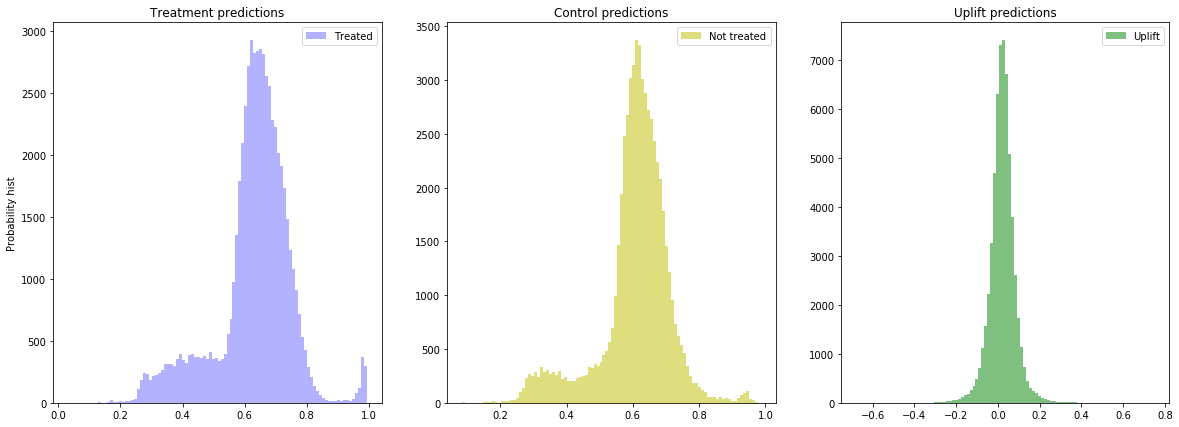

In [6]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Две зависимые модели

Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным: 
$$
P^C = P(Y=1| X, W = 0),
$$
затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

Чтобы получить uplift для каждого наблюдения, вычислим разницу:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

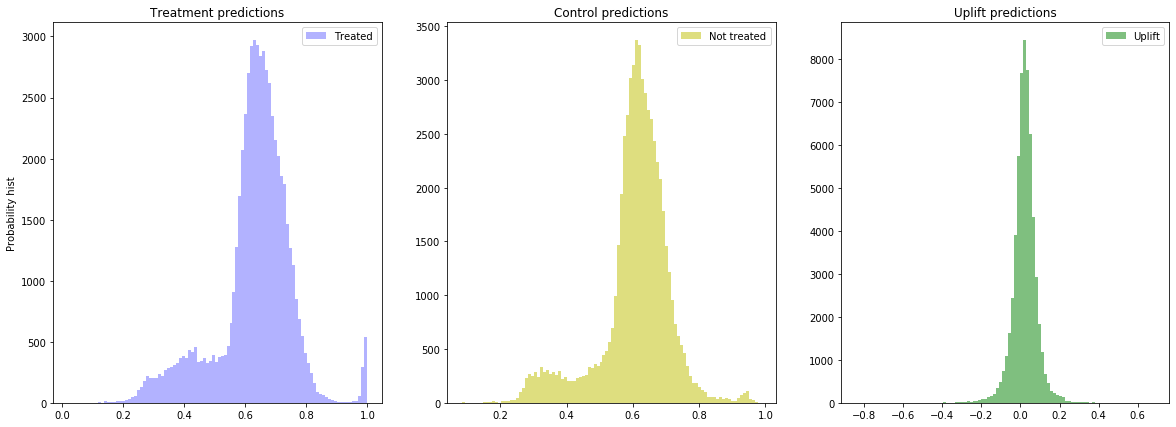

In [7]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

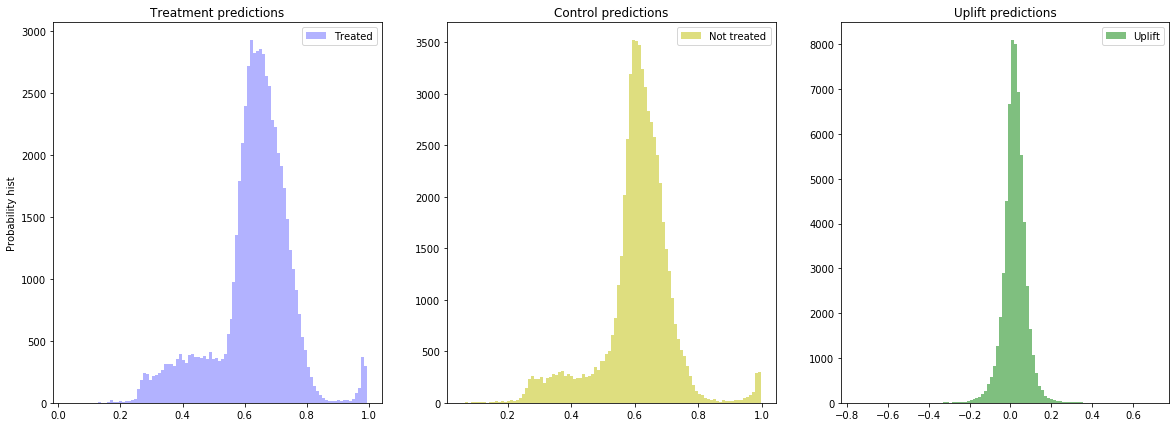

In [8]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Заключение

Рассмотрим, какой метод лучше всего показал себя в этой задаче, и проскорим им тестовую выборку:

In [9]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.052384
2,TwoModels,0.043493
3,TwoModels_ddr_control,0.041844
0,SoloModel,0.035962
4,TwoModels_ddr_treatment,0.030203


Из таблички выше можно понять, что в текущей задаче лучше всего справился подход трансформации целевой перемнной. Обучим модель на всей выборке и предскажем на тест.

In [11]:
cm_full = ClassTransformation(CatBoostClassifier(silent=True, thread_count=2, random_state=43))
cm_full = cm_full.fit(X_train_full, y_train_full, treat_train_full, estimator_fit_params={'cat_features': [1]})

X_test.loc[:, 'uplift'] = cm_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv('sub1.csv')

!head -n 5 sub1.csv

/Users/Maksim/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


client_id,uplift
000048b7a6,-0.018037283572946983
000073194a,0.08209120928550351
00007c7133,0.10180194944541898
00007f9014,0.059020888526841064


In [12]:
cm_full_fi = pd.DataFrame({
    'feature_name': cm_full.estimator.feature_names_,
    'feature_score': cm_full.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cm_full_fi

,feature_name,feature_score
0,first_redeem_time,39.008385
1,age,20.240392
2,issue_redeem_delay,17.446927
3,first_issue_time,17.037222
4,gender,6.267074


Итак, мы познакомились с uplift моделированием и рассмотрели основные классические подходы его построения. Что дальше? Дальше можно с головй окунуться в разведывательный анализ данных, генерацию новых признаков, подбор моделей и их гиперпарметров, а также изучение новых подходов и библиотек.

**Спасибо, что дочитали до конца.**

**Мне будет приятно, если вы поддержите проект звездочкой на [гитхабе](https://github.com/maks-sh/scikit-uplift/) или расскажете о нем своим друзьям.**